# 왕좌의 게임 기본 정보 (출연진 제외)

In [ ]:
# 왕좌의 게임 기본 정보 (출연진 제외)

from bs4 import BeautifulSoup
import pandas as pd
from urllib.request import urlopen, Request
from user_agent import generate_user_agent
import re



base_url = "https://www.imdb.com/title/tt0944947/episodes/?season={}&ref_=ttep"

season_list = []
episode_list = []
title_list = []
broadcast_date = []
rating_list = []

for season_num in range(1, 9):
    url = base_url.format(season_num)
    req = Request(url=url, headers={'User-Agent': generate_user_agent()})
    page = urlopen(req)
    soup = BeautifulSoup(page, "html.parser")

    for item in soup.find_all('div', 'sc-90c501a1-4 ihHLol'):
        full_title = item.find(class_='ipc-title__text ipc-title__text--reduced').string
        temp, title = full_title.split(' ∙ ')
        s_string, e_string = temp.split('.')
        season_value = int(s_string.replace('S', ''))
        episode_value = int(e_string.replace('E', ''))
        season_list.append(season_value)
        episode_list.append(episode_value)
        title_list.append(title)
        broadcast_date.append(item.find(class_='sc-90c501a1-10 hjpnXD').string)
        rating_list.append(item.find(class_='ipc-rating-star--rating').string)

df = pd.DataFrame({
    'Season': season_list,
    'Episode': episode_list,
    'Title': title_list,
    'Broadcast_date': broadcast_date,
    'Rating': rating_list
})

df.to_csv("../data/game.csv", sep="/", encoding="utf-8")

KeyboardInterrupt: 

# 배우, 출연진 정보 크롤링

In [ ]:
import pandas as pd

df = pd.read_csv("../data/got_cast_info_full.csv")

def clean_actor_list_strict(actor_string):
    if pd.isna(actor_string):
        return []
    return list(set([a.strip() for a in actor_string.split(",") if a.strip()]))

df["Actor List"] = df["Actors"].apply(clean_actor_list_strict)
df["Actor Count"] = df["Actor List"].apply(len)

# 저장
df.to_csv("got_cast_info_with_clean_actor_list.csv", index=False)

In [ ]:
actor_counts = df["Actors"].value_counts().reset_index()
actor_counts.columns = ["Actors", "Season"]

print(actor_counts.head(10))

                                              Actors  Episode
0  , Sean Bean, , Mark Addy, , Nikolaj Coster-Wal...        2
1  , Mark Addy, , Alfie Allen, , Sean Bean, , Esm...        1
2  , Sean Bean, , Mark Addy, , Nikolaj Coster-Wal...        1
3  , Sean Bean, , Mark Addy, , Nikolaj Coster-Wal...        1
4  , Sean Bean, , Mark Addy, , Nikolaj Coster-Wal...        1
5  , Sean Bean, , Mark Addy, , Michelle Fairley, ...        1
6  , Sean Bean, , Mark Addy, , Nikolaj Coster-Wal...        1
7  , Sean Bean, , Michelle Fairley, , Lena Headey...        1
8  , Sean Bean, , Michelle Fairley, , Nikolaj Cos...        1
9  , Sean Bean, , Michelle Fairley, , Nikolaj Cos...        1


In [35]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium_stealth import stealth
import pandas as pd
import time

# 셀레니움 옵션 설정
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(service=Service("../driver/chromedriver"), options=options)

stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True)

# 크롤링 대상 URL
url = "https://www.imdb.com/title/tt31321401/fullcredits/?ref_=tt_cst_sm"
driver.get(url)
time.sleep(2)  # 페이지 로딩 대기

rows = []

try:
    # 1. data-testid="sub-section-cast" 요소 찾기
    cast_section = driver.find_element(By.CSS_SELECTOR, "div[data-testid='sub-section-cast']")

    # 2. 배우 이름 a 태그 모두 찾기
    actors = cast_section.find_elements(By.CSS_SELECTOR, "a.ipc-link.ipc-link--base.name-credits--title-text.name-credits--title-text-big")
    # 3. 역할 이름 a 태그 모두 찾기
    roles = cast_section.find_elements(By.CSS_SELECTOR, "a.ipc-link.ipc-link--base.ipc-link--inherit-color")

    # 4. 배우, 역할 개수 맞추기 (둘 중 적은 개수만큼 반복)
    count = min(len(actors), len(roles))

    for i in range(count):
        actor_name = actors[i].text.strip()
        role_name = roles[i].text.strip().replace("\n", " / ")

        if actor_name:
            rows.append({
                "Actor": actor_name,
                "Role": role_name
            })

finally:
    driver.quit()

# 5. DataFrame 생성 및 출력
df = pd.DataFrame(rows)
print(df.head())

# 6. CSV 저장
df.to_csv("../data/1got_actors_and_roles.csv", index=False, encoding="utf-8")


                  Actor              Role
0             Mark Addy  Robert Baratheon
1           Alfie Allen     Theon Greyjoy
2             Sean Bean         Ned Stark
3           Esmé Bianco               Roz
4  Jamie Campbell Bower      Waymar Royce


In [36]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium_stealth import stealth
import pandas as pd
import time
from tqdm import tqdm

# 1. 시즌 1 에피소드 목록 로딩
df_game = pd.read_csv("../data/got_cast_info_full.csv")
df_s1 = df_game[df_game["Season"] == 1]

# 2. 셀레니움 설정
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(service=Service("../driver/chromedriver"), options=options)

stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True)

rows = []

# 3. 시즌1 에피소드별 반복 크롤링
for _, row in tqdm(df_s1.iterrows(), total=len(df_s1), desc="시즌1 배우+역할 크롤링"):
    season = row["Season"]
    episode = row["Episode"]
    ep_id = row["Episode ID"]

    url = f"https://www.imdb.com/title/{ep_id}/fullcredits"
    driver.get(url)
    time.sleep(2)  # 로딩 대기

    try:
        cast_section = driver.find_element(By.CSS_SELECTOR, "div[data-testid='sub-section-cast']")

        actors = cast_section.find_elements(By.CSS_SELECTOR, "a.ipc-link.ipc-link--base.name-credits--title-text.name-credits--title-text-big")
        roles = cast_section.find_elements(By.CSS_SELECTOR, "a.ipc-link.ipc-link--base.ipc-link--inherit-color")

        count = min(len(actors), len(roles))

        for i in range(count):
            actor_name = actors[i].text.strip()
            role_name = roles[i].text.strip().replace("\n", " / ")

            if actor_name:
                rows.append({
                    "Season": season,
                    "Episode": episode,
                    "Episode ID": ep_id,
                    "Actor": actor_name,
                    "Role": role_name
                })

    except Exception as e:
        print(f"[{season}-{episode}] 에러 발생: {e}")

    time.sleep(1)

driver.quit()

# 4. DataFrame 생성 및 저장
df_cast = pd.DataFrame(rows)
df_cast.to_csv("../data/got_s1_fullcredits_actor_role.csv", index=False, encoding="utf-8")
print(df_cast.head())


시즌1 배우+역할 크롤링: 100%|██████████| 11/11 [01:22<00:00,  7.49s/it]

   Season  Episode  Episode ID                 Actor              Role
0       1        1  tt31321401             Mark Addy  Robert Baratheon
1       1        1  tt31321401           Alfie Allen     Theon Greyjoy
2       1        1  tt31321401             Sean Bean         Ned Stark
3       1        1  tt31321401           Esmé Bianco               Roz
4       1        1  tt31321401  Jamie Campbell Bower      Waymar Royce


# 이게 진짜 시즌/에피소드별 배우 배역 크롤링 성공한 코드

In [38]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium_stealth import stealth
import pandas as pd
import time
from tqdm import tqdm

# 1. 전체 시즌 에피소드 목록 로딩
df_game = pd.read_csv("../data/got_cast_info_full.csv")

# 2. 셀레니움 설정
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(service=Service("../driver/chromedriver"), options=options)

stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True)

rows = []

# 3. 시즌 1~8 전체 에피소드 반복
for _, row in tqdm(df_game.iterrows(), total=len(df_game), desc="전체 시즌 배우+역할 크롤링"):
    season = row["Season"]
    episode = row["Episode"]
    ep_id = row["Episode ID"]

    url = f"https://www.imdb.com/title/{ep_id}/fullcredits"
    driver.get(url)
    time.sleep(2)  # 로딩 대기

    try:
        cast_section = driver.find_element(By.CSS_SELECTOR, "div[data-testid='sub-section-cast']")

        actors = cast_section.find_elements(By.CSS_SELECTOR, "a.ipc-link.ipc-link--base.name-credits--title-text.name-credits--title-text-big")
        roles = cast_section.find_elements(By.CSS_SELECTOR, "a.ipc-link.ipc-link--base.ipc-link--inherit-color")

        max_count = max(len(actors), len(roles))

        for i in range(max_count):
            actor_name = actors[i].text.strip() if i < len(actors) else ""
            role_name = roles[i].text.strip().replace("\n", " / ") if i < len(roles) else ""

            if actor_name or role_name:  # 둘 다 공백이면 저장 안 함
                rows.append({
                    "Season": season,
                    "Episode": episode,
                    "Episode ID": ep_id,
                    "Actor": actor_name,
                    "Role": role_name
                })

    except Exception as e:
        print(f"[시즌{season} 에피소드{episode}] 에러 발생: {e}")

    time.sleep(1)

driver.quit()

# 4. DataFrame 생성 및 저장
df_cast_all = pd.DataFrame(rows)
df_cast_all.to_csv("../data/got_all_seasons_fullcredits_actor_role.csv", index=False, encoding="utf-8")
print(df_cast_all.head())


전체 시즌 배우+역할 크롤링: 100%|██████████| 74/74 [08:25<00:00,  6.83s/it]

   Season  Episode  Episode ID                 Actor              Role
0       1        1  tt31321401             Mark Addy  Robert Baratheon
1       1        1  tt31321401           Alfie Allen     Theon Greyjoy
2       1        1  tt31321401             Sean Bean         Ned Stark
3       1        1  tt31321401           Esmé Bianco               Roz
4       1        1  tt31321401  Jamie Campbell Bower      Waymar Royce


In [10]:
# got_all_seasons_fullcredits_actor_ > gameinfo.csv 로 변경

import pandas as pd

df = pd.read_csv("../data/gameinfo.csv")


# 배우별 시즌-에피소드 출연 여부를 피벗테이블로 변환 (1 출연, 0 미출연)
df['Presence'] = 1
pivot = df.pivot_table(index='Actor', columns=['Season', 'Episode'], values='Presence', fill_value=0)

# 출연 여부를 시즌-에피소드 순서대로 정렬
pivot = pivot.sort_index(axis=1, level=[0,1])

# 사망 추정을 저장할 DataFrame 초기화
death_records = []

# 시즌, 에피소드 리스트
season_episode_list = sorted(pivot.columns.tolist())

# 배우별로 출연 여부 비교
for actor in pivot.index:
    appearances = pivot.loc[actor].values  # 출연 여부 배열
    # 이전 에피소드에 출연했다가 이번 에피소드에 없으면 사망 추정
    for i in range(1, len(appearances)):
        if appearances[i-1] == 1 and appearances[i] == 0:
            death_records.append({
                'Actor': actor,
                'Death_Season': season_episode_list[i][0],
                'Death_Episode': season_episode_list[i][1]
            })
            break  # 최초 사망 추정 지점 기록 후 종료

# 결과 DataFrame
death_df = pd.DataFrame(death_records)

print(death_df)

                   Actor  Death_Season  Death_Episode
0           A.J. Kennedy             3             10
1          Adam Devereux             8              6
2             Adam Slynn             8              1
3             Adam Turns             6              9
4    Adele Smyth-Kennedy             7              6
..                   ...           ...            ...
677       Xena Avramidis             4              4
678   Yousef 'Joe' Sweid             6              5
679    Yuri Kolokolnikov             4              2
680      Zachary Baharov             5              9
681           Zoi Gorman             6              8

[682 rows x 3 columns]


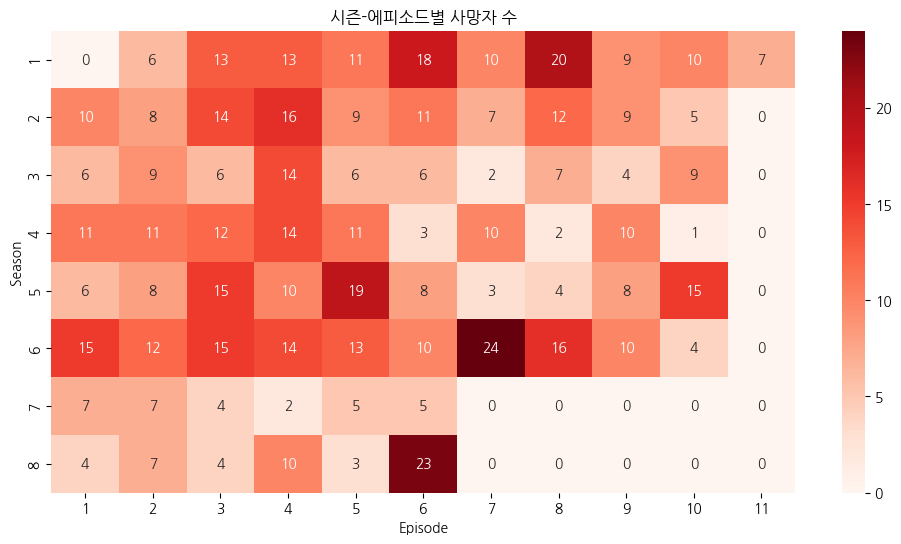

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# 시즌과 에피소드별 사망자 수 집계
death_counts = death_df.groupby(['Death_Season', 'Death_Episode']).size().reset_index(name='Death_Count')

# 시즌과 에피소드별 사망자 수 피벗 테이블로 변환
pivot_death = death_counts.pivot(index='Death_Season', columns='Death_Episode', values='Death_Count').fillna(0)

# 시즌과 에피소드가 숫자형이라면 정렬 확인
pivot_death = pivot_death.sort_index().sort_index(axis=1)

# 시각화
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_death, annot=True, fmt=".0f", cmap="Reds")
plt.title('시즌-에피소드별 사망자 수')
plt.xlabel('Episode')
plt.ylabel('Season')
plt.show()


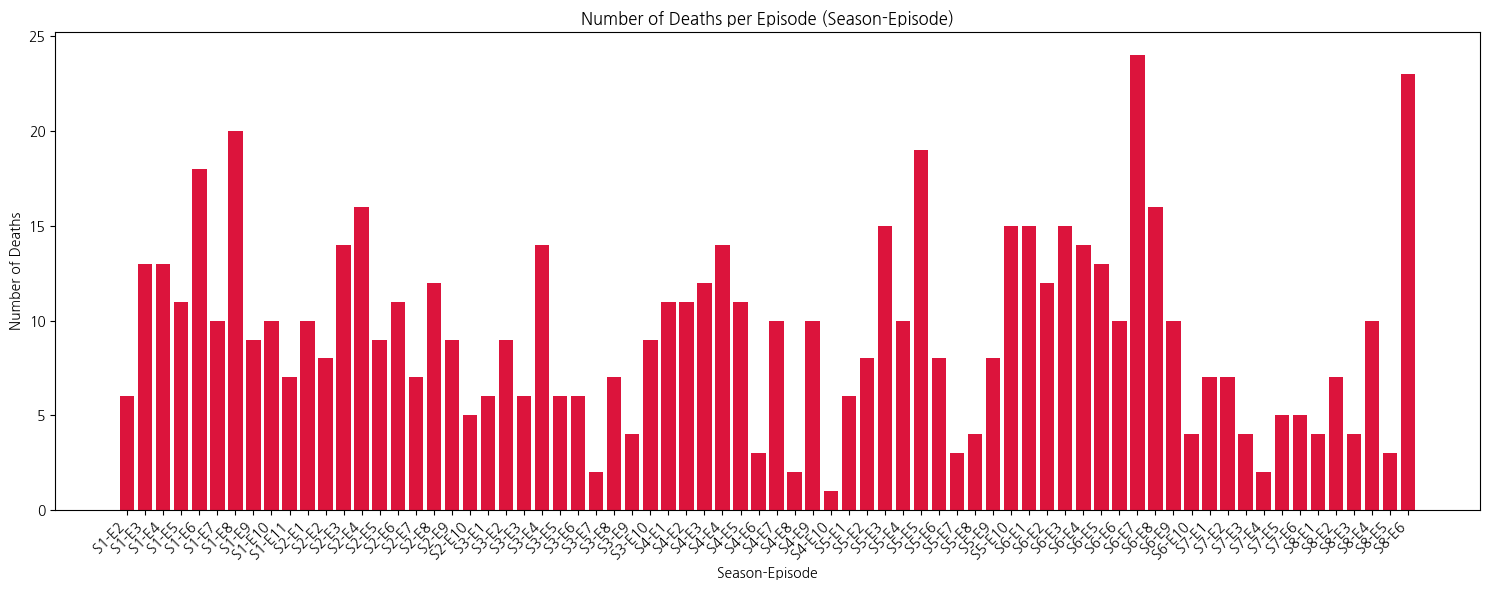

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


# 시즌+에피소드별 사망자 수 집계
death_counts = death_df.groupby(['Death_Season', 'Death_Episode']).size().reset_index(name='Death_Count')

# 시즌과 에피소드 합친 라벨 만들기 (예: S1-E3)
death_counts['Season_Episode'] = death_counts.apply(lambda x: f"S{x['Death_Season']}-E{x['Death_Episode']}", axis=1)

# 시즌-에피소드별 사망자 수 내림차순 정렬 또는 시즌,에피소드 순서대로 정렬 (원하는대로)
death_counts = death_counts.sort_values(by=['Death_Season', 'Death_Episode'])

plt.figure(figsize=(15,6))
plt.bar(death_counts['Season_Episode'], death_counts['Death_Count'], color='crimson')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Season-Episode')
plt.ylabel('Number of Deaths')
plt.title('Number of Deaths per Episode (Season-Episode)')
plt.tight_layout()
plt.show()
